In [3]:
import json
import matplotlib.pyplot as plt

import bluepyopt as bpopt
import bluepyopt.ephys as ephys

import model
import evaluator
import time

import sys

from pathlib import Path

In [4]:
#!rm -r x86_64
#!nrnivmodl mechanisms

In [5]:
probe = None #model.define_electrode(probe_type="linear")

In [6]:
cell = model.create(morph_modifier="hillock", release=True)

param_names = [param.name for param in cell.params.values() if not param.frozen]

fitness_protocols = evaluator.define_protocols(
    feature_set=None, 
    feature_file=None, 
    electrode=probe,
    protocols_with_lfp=None
)

fitness_calculator = ephys.objectivescalculators.ObjectivesCalculator([])

sim = ephys.simulators.LFPySimulator(cell, cvode_active=True, electrode=probe)

eva = ephys.evaluators.CellEvaluator(                    
        cell_model=cell,                                                       
        param_names=param_names,                                                    
        fitness_protocols=fitness_protocols,                                        
        fitness_calculator=fitness_calculator,                                      
        sim=sim)

In [7]:
fitness_protocols

{'bAP': <bluepyopt.ephys.protocols.SweepProtocol at 0x7ff813d895e0>,
 'BAC': <bluepyopt.ephys.protocols.SweepProtocol at 0x7ff813d89a60>,
 'EPSP': <bluepyopt.ephys.protocols.SweepProtocol at 0x7ff813d89f10>,
 'CaBurst': <bluepyopt.ephys.protocols.SweepProtocol at 0x7ff813d8c3d0>,
 'Step1': <bluepyopt.ephys.protocols.SweepProtocol at 0x7ff813d8c850>}

In [8]:
t_start = time.time()
responses = eva.run_protocols(protocols=fitness_protocols.values(), param_values={})
print(f"Elapsed time: {time.time() - t_start}")

Elapsed time: 40.33006024360657


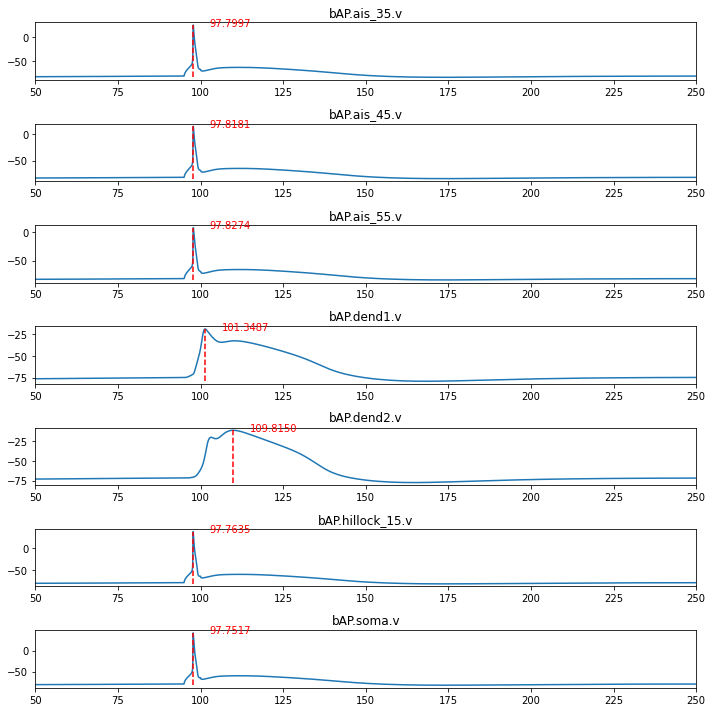

In [19]:
fig, axes = plt.subplots(7, figsize=(10, 10), squeeze=False)
index = 0

import numpy

for resp_name, response in sorted(responses.items()):
    
    if response and "bAP" in resp_name:

        axes[index, 0].plot(response['time'], response['voltage'], label=resp_name)
        axes[index, 0].set_title(resp_name)

        idx_max = numpy.argmax(response['voltage'])
        
        axes[index, 0].plot(
            [response['time'][idx_max], response['time'][idx_max]],
            [numpy.min(response['voltage']), numpy.max(response['voltage'])],
            color='red',
            ls='--'
        )
        axes[index, 0].text(
            response['time'][idx_max] + 5,
            numpy.max(response['voltage']) - 1.5,
            "{:.4f}".format(response['time'][idx_max]),
            color='red',
        )
        axes[index, 0].set_xlim(50, 250)
        index += 1
        
        
fig.tight_layout()
fig.show()

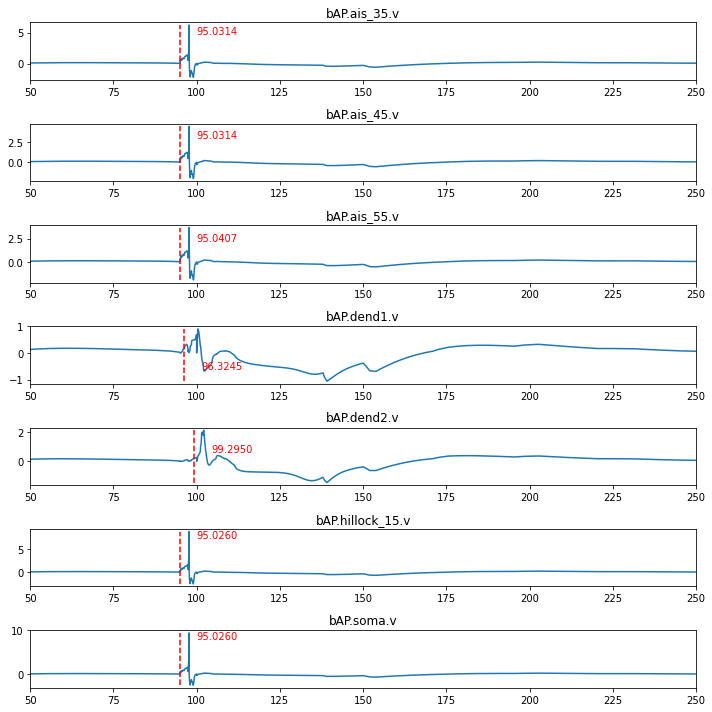

In [18]:
fig, axes = plt.subplots(7, figsize=(10, 10), squeeze=False)
index = 0

import numpy

for resp_name, response in sorted(responses.items()):
    
    if response and "bAP" in resp_name:
        
        gradient = numpy.gradient(response['voltage'])
        axes[index, 0].plot(response['time'], gradient, label=resp_name)
        axes[index, 0].set_title(resp_name)
        
        t_start_search = numpy.argmax(response['time']>50.)
        idx_max = numpy.argmax(gradient[t_start_search:]>0.2) +  t_start_search
        axes[index, 0].plot(
            [response['time'][idx_max], response['time'][idx_max]],
            [numpy.min(gradient), numpy.max(gradient)],
            color='red',
            ls='--'
        )
        axes[index, 0].text(
            response['time'][idx_max] + 5,
            numpy.max(gradient) - 1.5,
            "{:.4f}".format(response['time'][idx_max]),
            color='red',
        )
        axes[index, 0].set_xlim(50, 250)
        index += 1
        
        
fig.tight_layout()
fig.show()